# Assignment 2


In [1]:
import pickle
import pandas as pd
import urllib.request
import json
import math 
import ast
import re
from itertools import islice
from urllib.parse import quote
import os
import numpy as np
import matplotlib.pyplot as plt

### Data

In [2]:
# 1. Load names/wiki links dictionary
def extractDataFiles(filename):
    marvel = pd.read_csv(filename +".csv")
    marvel_wikilinks = marvel.loc[:, 'WikiLink']
    marvel_characters = marvel_wikilinks[marvel_wikilinks.notna()].to_numpy()

    all_marvel = {}

    for name in marvel_characters:
        character = name.replace(" ", "_")
        all_marvel[character] = character

    return all_marvel

In [3]:
# 1. calling the functions
marvel = extractDataFiles('marvel')
dc = extractDataFiles('dc')

In [4]:
# 3. create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLs(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + wiki
        content = "prop=revisions&rvprop=content"
        only_links = "prop=links&pllimit=max"
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

In [5]:
DC_url_query_directory_Links = createURLs(dc)
marvel_url_query_directory_Links = createURLs(marvel)

In [6]:
# 3.1 create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLsPages(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + wiki
        content = "prop=revisions&rvprop=content"
        only_links = "&pllimit=max"
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    return url_query_list

In [7]:
marvel_url_query_directory_pages = createURLsPages(marvel)
DC_url_query_directory_pages = createURLsPages(dc)

In [8]:
# 4. Send request

def sendWikiRequests(url_list):
    response_wiki_dir = {}

    for name,url in url_list.items():
        try:
            wikiresponse = urllib.request.urlopen(url)
            wikidata = wikiresponse.read()
            wikitext = wikidata.decode('utf-8')
        
            wiki_json = json.loads(wikitext)
            response_wiki_dir[name] = wiki_json
        except:
            pass
        
    return response_wiki_dir

In [9]:
def connectLinksPages(link_Directory,page_Directory):
    full_dict = {}
    
    for name, wiki in link_Directory.items():
        links = str(wiki)        
        pages = str(page_Directory[name])
        full = links + '***' + pages
        full_dict[name] = full
    return full_dict

In [10]:
# Save to file
import os.path

def saveWikiJsonFiles(name_wiki,universe):
    for name,wiki in name_wiki.items():
        
        save_path = str(universe)+'/'
        name = name.replace('|','')
        completeName = os.path.join(save_path, name+".txt")      
        try:
            with open(completeName, "w") as text_file:
                    text_file.write(str(wiki))
        except:
            pass        

In [11]:
should_fetch_information_from_wikipedia = False 
# This is necessary only once -- afterwards it's much faster to read the information from .txt files
# Please set to True, if the stored .txt files have been deleted, or should be rewritten

if should_fetch_information_from_wikipedia:
    # Construct all responses
    DC_wiki_json_responses = sendWikiRequests(DC_url_query_directory_Links)
    marvel_wiki_json_responses = sendWikiRequests(marvel_url_query_directory_Links)
    dc_wiki_responses_pages = sendWikiRequests(DC_url_query_directory_pages)
    marvel_wiki_responses_pages = sendWikiRequests(marvel_url_query_directory_pages)
    
    # Put all information together, in a dictionary
    dcFull = connectLinksPages(DC_wiki_json_responses, dc_wiki_responses_pages) 
    marvelFull = connectLinksPages(marvel_wiki_json_responses, marvel_wiki_responses_pages) 
    
    # Save the information to a text files, in different directory for each universe
    saveWikiJsonFiles(marvelFull, 'marvel')
    saveWikiJsonFiles(dcFUll, 'dc')

**Read the data from the stored text files.**

In [12]:
import os.path
def readWikiJsonFiles(name_wiki,universe):
    
    name_wiki_json = {}
    
    for name,wiki in name_wiki.items():
        temp = []
        save_path = str(universe)+'/'
        completeName = os.path.join(save_path, name+".txt") 
        try:
            with open(completeName, "r") as text_file:
                f = text_file.read()
                name_wiki_json[name] = json.loads(json.dumps(f))
        except:
            pass
    
    return name_wiki_json


In [13]:
marvel_name_wiki = readWikiJsonFiles(marvel_url_query_directory_Links, 'marvel')
DC_name_wiki = readWikiJsonFiles(DC_url_query_directory_Links, 'dc')

In [14]:
# preprocessing full pages / links
def splitLinksPages(text_file_list):
    
    name_wiki_dict = {}
    
    for name, wiki in text_file_list.items():
        x = wiki.split("***")    
        name_wiki_dict[name] = x
    
    return name_wiki_dict

In [15]:
DC_name_wiki_processed = splitLinksPages(DC_name_wiki)
marvel_name_wiki_processed = splitLinksPages(marvel_name_wiki)


In [16]:
# 5. extractLinks for each title,
# @return array of names(links) to other pages
def extractNodeNeighbors(directory):
    
    linkList = []
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) != 0):
            break
        else:
            title = directory[i]['title']
            linkList.append(title)
    
    return linkList

# 5.1 Check if site is redirect
def checkIfRedirect(directory):
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) == 4):
            title = directory[i]['title']
            if "redirect" in title: 
                print('redirect')
                return 0
            else:
                return 1
        else:
            return 1

def wiki_json_preprocessing(directory):
    
    name_neighbors = {}
    
    for name,value_json in directory.items():
        try:
            value_json = value_json[0]
            value_json = ast.literal_eval(value_json)
        except:
            continue
        non_unique = value_json['query']['pages'].keys()
        non_unique = next(iter(non_unique))
        
        try:    
            link_dir = value_json['query']['pages'][non_unique]['links']
        except:
            continue
        #check for redirect
        
        try:
            if(checkIfRedirect(link_dir) == 0):
                print(directory[name] + ' DELETED')
                del directory[name]                
                continue
        except:
            pass
        else:
            node_neighbors = extractNodeNeighbors(link_dir)
                
        name_neighbors[name] = node_neighbors
        
    return name_neighbors      

In [17]:
marvel_name_nodeLinks = wiki_json_preprocessing(marvel_name_wiki_processed)
DC_name_nodeLinks = wiki_json_preprocessing(DC_name_wiki_processed)

**For each link you extract, check if the target is a character from your DC/Marvel lists. If yes, keep it. If no, discard it.**

In [18]:
def checkFromTargetUniverse(character_nodes, universe):
    return list(set(character_nodes) & set(universe))

In [19]:
# Marvel check

def removeEmptyData():
    deleteMarvel = []
    deleteDC = []
    
    for name, links in marvel_name_wiki_processed.items():
        if(len(links) == 1):
            print('DELETED : ', name)
            deleteMarvel.append(name)

    for i in deleteMarvel:
         del marvel_name_wiki_processed[i]

    for name, links in DC_name_wiki_processed.items():
        if(len(links) == 1):
            print('DELETED : ', name)
            deleteDC.append(name)
    for i in deleteDC:
         del DC_name_wiki_processed[i]

def removeRandomCharacters(name_links): 
    summ = 0
    
    for name, links in name_links.items():
        x_dc = checkFromTargetUniverse(links, dc)
        x_marvel = checkFromTargetUniverse(links, marvel)
        
        x_final = list(set().union(x_dc, x_marvel))
        summ += len(x_final)
        name_links[name] = x_final
    
    print('key -> value ::: sum of all edges in the values field ', summ)
    
    return name_links

In [20]:
removeEmptyData()

print('marvel')
marvel_name_nodeLinks = removeRandomCharacters(marvel_name_nodeLinks)
print('marvel nodes number : ', len((marvel_name_nodeLinks)))

print()
print('dc')
DC_name_nodeLinks = removeRandomCharacters(DC_name_nodeLinks)
print('DC nodes number ', len((DC_name_nodeLinks)))


marvel
key -> value ::: sum of all edges in the values field  21814
marvel nodes number :  1727

dc
key -> value ::: sum of all edges in the values field  6468
DC nodes number  434


#### Use a NetworkX DiGraph to store the network. As noted above, remember to store the properties of the nodes (i.e. from which universe they hail).


In [21]:
# IMPORTS
import networkx as nx

In [22]:
# G.add_node('abc', dob=1185, pob='usa', dayob='monday')

G = nx.DiGraph()

#marvel
for name in marvel_name_nodeLinks.keys():
    G.add_node(name, universe = 'marvel')

#dc
for name in DC_name_nodeLinks.keys():
    G.add_node(name, universe = 'dc')

for name, connections in marvel_name_nodeLinks.items(): 
    for i in range(len(connections)):
        G.add_edge(name, connections[i])
        
for name, connections in DC_name_nodeLinks.items(): 
    for i in range(len(connections)):
        G.add_edge(name, connections[i])

### Basic Stats

In [23]:
import numpy as np
from statistics import mode # numpy doesn't have mode and median API :(

# Get basic stats of the network
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

# In degrees
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)

print("In-degree average: ", np.average(degree_sequence))
print("In-degree mode: ", mode(degree_sequence))
print("In-degree median: ", np.median(degree_sequence))
print("In-degree min: ", np.min(degree_sequence))
print("In-degree max: ", np.max(degree_sequence))
print()

# Out degrees
degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
print("Out-degree average: ", np.average(degree_sequence))
print("Out-degree mode: ", mode(degree_sequence))
print("Out-degree median: ", np.median(degree_sequence))
print("Out-degree min: ", np.min(degree_sequence))
print("Out-degree max: ", np.max(degree_sequence))

Number of nodes:  2161
Number of edges:  28282
In-degree average:  13.087459509486349
In-degree mode:  0
In-degree median:  0.0
In-degree min:  0
In-degree max:  562

Out-degree average:  13.087459509486349
Out-degree mode:  0
Out-degree median:  7.0
Out-degree min:  0
Out-degree max:  54


**Summary of the basic statistics**

Our network consists of 2161 nodes, and 28282 edges. Considering the in-degree distribution, the average in-degree is 13.09, both the mode and median are equal to 0, the minimum is 0, and the maximum is 562. It's quite interesting to see that majority of the nodes have an in-degree of 0, meaning that no other character refers to them, and the maximum is relatively high, which suggests a power law distribution. As for the out-degree, the average is exactly the same, 13.09, the mode is 0, the median is 7.0, the minimum is 0 and the maximum is 54. From this, we can see that the out-degree distribution is somewhat more flat -- in a way that the maximum is much smaller than that of in-degree, and the median is 7.0, as opposed to 0.

Values less than or equal to 0 in data. Throwing out 0 or negative values


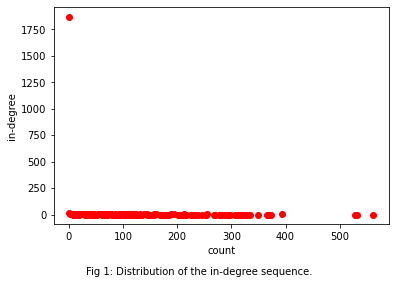

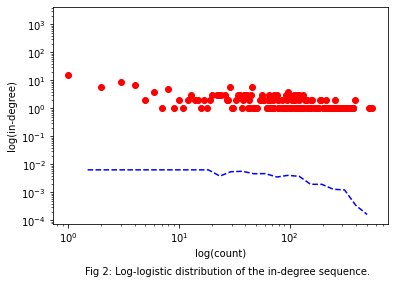

In [39]:
# Plotting in-degree distribution
# !pip install powerlaw
import powerlaw
import collections
import matplotlib.pyplot as plt
import numpy as np

# In degrees
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
in_degrees, in_counts = zip(*degree_count.items())

# Calculate the exponent of the degree distribution
fit = powerlaw.Fit(in_degrees, xmin=-500, xmax=20000)

fig, norm_ax = plt.subplots()
norm_ax.plot(in_degrees, in_counts, 'ro')
plt.xlabel("count")
plt.ylabel("in-degree")
fig.text(.2, -.05, "Fig 1: Distribution of the in-degree sequence.")
plt.show()

fig, loglog_ax = plt.subplots()
loglog_ax.loglog(in_degrees, in_counts, 'ro')
plt.xlabel("log(count)")
plt.ylabel("log(in-degree)")
fit.plot_pdf(color= 'b', linestyle='--', ax=loglog_ax)
fig.text(.2, -0.05, "Fig 2: Log-logistic distribution of the in-degree sequence.")
plt.show()

**Analysis of the distribution**

The majority of the nodes have a degree of 0, while the few most-popular nodes have a very highe degree, as can be seen Fig 1. This resembles a scale free distribution, therefore, for the sake of better visualization, we plotted it as a loglog graph, along with the exponent of the degree distribution calculated using the powerlaw package, see Fig 2. These visualizations provide a useful insight into the network: We can see that a lot of characters refer to a very popular character -- such as Spider-Man -- while no other nodes refer to them.

Values less than or equal to 0 in data. Throwing out 0 or negative values
/Users/kar/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


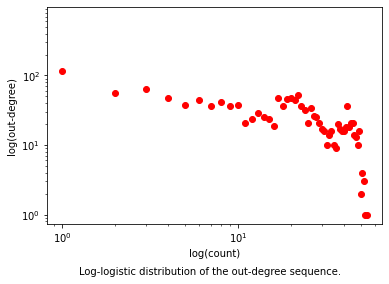

In [40]:
# Plotting out-degree distribution

degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
out_degrees, out_counts = zip(*degree_count.items())

# Calculate the exponent of the degree distribution
fit = powerlaw.Fit(out_degrees, xmin=-1000, xmax=1000)

fig, main_ax = plt.subplots()
main_ax.loglog(out_degrees, out_counts, 'ro')
plt.xlabel("log(count)")
plt.ylabel("log(out-degree)")
fig.text(.2, -.05, "Log-logistic distribution of the out-degree sequence.")
plt.show()

Comparatively, the out-degree distibution, plotted on a loglog scale, has a more steadily-increasing distribution: there's much fewer nodes with out-degree of 0, and although some nodes have a huge out-degree, the number of those nodes is smaller, compared to the in-degree distribution, and much more nodes and medium-to-high out-degrees. This means that in general, in our network, characters tend to refer mostly to the most popular characters, and the less popular characters don't refer to each other as much.

In [41]:
# Plotting the network using ForceAtlas algorithm

# First, let's extract the giant connected component: it will be more interesting to visualize
subgraphs = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
GCC = subgraphs[0]
for subgraph in subgraphs[1:]:
    if subgraph.number_of_nodes() > GCC.number_of_nodes():
        GCC = subgraph
        
GCC_undirected = GCC.to_undirected()

# Universe attribute
attributes_dict = {}
for i in marvel_name_nodeLinks.keys():
    attributes_dict[i] = "marvel"

for i in DC_name_nodeLinks.keys():
    attributes_dict[i] = "dc"

nx.set_node_attributes(GCC_undirected, attributes_dict, name="universe")

In [42]:
# !pip install fa2
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:30<00:00, 64.69it/s]

BarnesHut Approximation  took  8.46  seconds
Repulsion forces  took  20.62  seconds
Gravitational forces  took  0.16  seconds
Attraction forces  took  0.47  seconds
AdjustSpeedAndApplyForces step  took  0.54  seconds


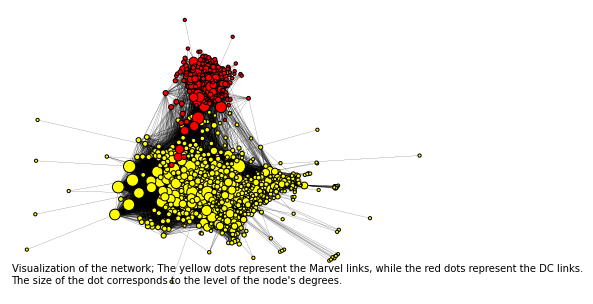

In [45]:
import collections

node_colors = []

for node in list(GCC_undirected.nodes()):
    if node in DC_name_nodeLinks:
        node_color = "#FF0000"
    else:
        node_color = "#FFFF00"
    node_colors.append(node_color)

degree_sequence = [d for n, d in GCC_undirected.degree()]
degree_count = collections.Counter(degree_sequence)

offset = 10
scale = 200
degree_range = float(max(degree_sequence) - min(degree_sequence))
node_sizes = [offset + scale * degree / degree_range for degree in degree_sequence]

fig = plt.figure()
nx.draw(GCC_undirected, pos=positions, node_size=node_sizes, node_color=node_colors, width=0.15, edgecolors="#000000", linewidths=1)
caption = """
Visualization of the network; The yellow dots represent the Marvel links, while the red dots represent the DC links. 
The size of the dot corresponds to the level of the node's degrees.
"""
fig.text(0.01, 0.0001, caption)
plt.show()

### Communities

In [46]:
# graph for community decetion
import networkx as nx
from networkx.algorithms import community

dc_graph = nx.DiGraph()

op = 0
# add nodes to the graph
for name, connections in DC_name_nodeLinks.items():
    dc_graph.add_node(name, universe = 'dc')
# add edges
for name, connections in DC_name_nodeLinks.items(): 
    for i in range(len(connections)):
        dc_graph.add_edge(name, connections[i])


dc_undirected = dc_graph.to_undirected()


subgraphs_dc = [dc_graph.subgraph(c) for c in nx.weakly_connected_components(dc_graph)]
GCC_dc = subgraphs_dc[0]
for subgraph in subgraphs_dc[1:]:
    if subgraph.number_of_nodes() > GCC_dc.number_of_nodes():
        GCC_dc = subgraph
# TypeError: 'float' object is not callable BUG WITH THE COMPILER

In [49]:
# !pip install community
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

#first compute the best partition
dc_undirected.remove_nodes_from(list(nx.isolates(dc_undirected )))

partition = community.louvain_communities(dc_undirected)
partition.sort()


ModuleNotFoundError: No module named 'community.community_louvain'

In [ ]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(dc_undirected , pos=None, iterations=2000)

In [ ]:
c = 0
cls = []
for i in partition:
    for x in i:
        cls.append(c)
    c += 1   

import collections 

degree_sequence = [d for n, d in dc_undirected.degree()]
degree_count = collections.Counter(degree_sequence)

offset = 10000
scale = 80000
range = float(max(degree_sequence) - min(degree_sequence))
node_sizes = [offset + scale * degree / range for degree in degree_sequence]
fig = plt.figure(1, figsize=(150, 100), dpi=60)

nx.draw(dc_undirected, pos=positions, node_size=node_sizes, width=0.15, node_color=cls, edgecolors="#000000", linewidths=1)


#### Write a paragraph about your work to identify the communities. The paragraph should include

##### Information about the algorithm you used to find communities.
- Algorithm is split in 2 phases that are iteratively repeated. The algo assumes that there are N nodes in initial weighted network. Each node of the network is first assigned as a unique community so there are as many communities in division as there are nodes. So this first pass of the algorithm finds the natural partitions of the network. Next,  the node i is removed, and we are measuring the gain of modularity by placing that node in the community of j. In the end, the node i is place in the community j where the global gain is maximum. 


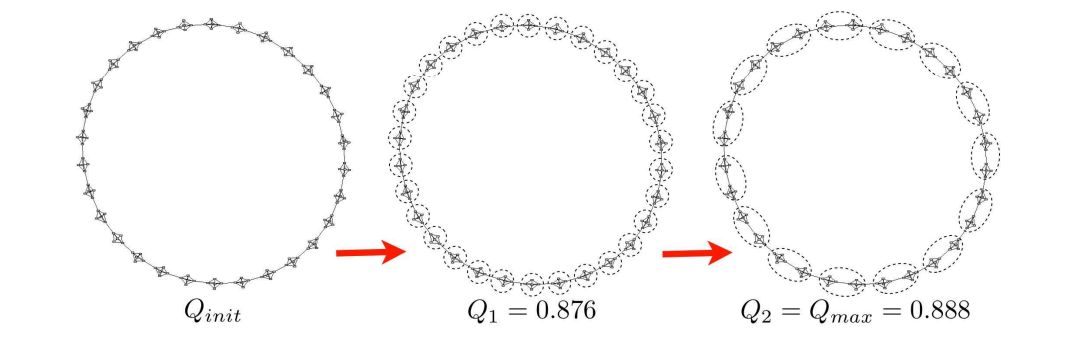


##### The value of modularity for your network.
- Modularity is used to detect community structures in the network. Thus, high modularity is desired for a network as it can reveal unexpected structural characteristics and enhance our understanding regarding the dynamics of the network. In the case of the marvel network, we can see the communities of each of the characters and for example, if we had data on each episode, movie, commic we could analyze that time seris to see how they coalesce through time. 

##### The number of communities and their sizes (in terms of number of nodes).
- Basic stats are bellow

In [ ]:
print('The number of communities is :', len(partition))

partition.sort(key=len, reverse = True)

top3 = partition[:3]
last3 = partition[-3:]
#
print('Top 3 ')
for i in top3:
    print('*', len(i))
print()

for i in last3:
    print('*', len(i))



In [ ]:
def removeEmptyData():
    deleteDC = []

    for name, links in DC_name_wiki_processed.items():
        if(len(links) == 1):
            #print('DELETED : ', name)
            deleteDC.append(name)
    for i in deleteDC:
         del DC_name_wiki_processed[i]
            
    deleteMarvel = []

    for name, links in marvel_name_wiki_processed.items():
        if(len(links) == 1):
            #print('DELETED : ', name)
            deleteMarvel.append(name)
    for i in deleteMarvel:
         del marvel_name_wiki_processed[i]

removeEmptyData()            

In [ ]:
def splitPartitions(partitions):
    coms = {}
    y = len(partition)

    i = 0

    while i < y:
      coms[i] = partition[i]
      i += 1
    
    return coms

In [ ]:
communities_directory = splitPartitions(partition)

In [ ]:
import nltk, re, pprint
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
import math
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

def wordcloudcommunity(community_number, community_dc):
    tf_dc = {}
    other_documents = []
    porter = nltk.PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')

    for character in community_dc:
        if character in DC_name_wiki_processed:
            doc = DC_name_wiki_processed[character][1]
        else:
            continue
        other_documents.append(doc)
        tokens = tokenizer.tokenize(doc)
        tokens = [w.lower() for w in tokens]
        # tokens = [porter.stem(w) for w in tokens]

        for token in tokens:
            if token in tf_dc:
                tf_dc[token] += 1
            else:
                tf_dc[token] = 1
    tf_dc = dict(sorted(tf_dc.items(), key=lambda item: item[1], reverse=True))
    # We have only two documents
    N = len(community_dc) 

    idf_dc = {}

    for word in tf_dc.keys():
        n = 0
        for doc in other_documents:
            if word in doc:
                n += 1

        idf_dc[word] = math.log(N / (n + 1)) + 1
        
    tf_idf_dc = {}
    for word in tf_dc.keys():
        tf_idf_dc[word] = tf_dc[word] * idf_dc[word]
    
    stopwords2 = set(STOPWORDS)
    stopwords2.update(["ref", "the","wa", "title", "cite", "web","x", "url"]) #wiki syntax

    wordcloud = WordCloud(stopwords=stopwords2, background_color="white", max_words=50).generate_from_frequencies((tf_idf_dc))


    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [ ]:
for key, value in communities_directory.items():
    wordcloudcommunity(key, value)

### Sentiment

>First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

In [24]:
# IMPORTS
import nltk, pprint
from nltk.corpus import stopwords

In order to calculate the sentiment for all character pages we first give a measurement of hapiness of a list of tokens. This list of tokens are given to us by the file _LabMT.txt_ in this repository.

In [26]:
# Extract a list of words with their hapiness score
labmt = np.loadtxt('labmt.txt', dtype=str, delimiter='\t')
header = labmt[0, :]
word_list = labmt[1:, :]

# Function that extracts the sentiment of a list of tokens
def getSentiment(tokens):
    results = []
    for token in tokens:
        index, _ = np.where(token == word_list)
        if len(index) > 0:
            word_sentiment = word_list[index[0], 2]
            results.append(float(word_sentiment))
        else:
            results.append(0.0)
    return results

In [27]:
# Function to clean text: remove punctuation, lower case, tokenize, lemmatize, remove stopwords and remove wikilinks.

def processText(text):
    
    # Remove punctuation
    no_punct = re.sub(r'[^\w\s]', ' ', text)
    no_punct = re.sub(r'\n', ' ', no_punct)
        
    # Lower case
    no_punct = no_punct.lower()
    
    # Tokenizer
    text = nltk.word_tokenize(no_punct)
        
    # Lemmatizer
    wnl = nltk.WordNetLemmatizer()
    tokens = [wnl.lemmatize(t) for t in text]
    
    # Remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [w for w in tokens if w.lower() not in stopwords]
        
    # Remove wiki syntax
    wikiwords = ["ref", "wa", "title", "cite", "web","x", "url"]
    tokens = [w for w in tokens if w.lower() not in wikiwords]
    
    return tokens


# Function to calculate the sentiment of a document based on the list of tokens

def getSentimentDocument(tokens):
    df1 = pd.DataFrame({"token":list(set(tokens))})
    df1["freq"] = df1["token"].apply(lambda x: nltk.FreqDist(tokens)[x])
    df1["score"] = df1["token"].apply(lambda x: getSentiment([x])[0])
    df1["score"] = df1["score"] * df1.freq
    sentiment_score = df1["score"].sum() / df1[df1.score != 0]["freq"].sum()
    return sentiment_score

In [29]:
should_get_sentiments_of_characters_files = False
# This is necessary only once -- afterwards it's much faster to read the sentiments_dict.csv file
# Set to True if the sentiments dictionary should be rewritten

if should_get_sentiments_of_characters_files:
    
    # Dictionary in which the keys are the characters and the values are the list of tokens of their wiki page
    tokens_dict = {}

    # Marvel pages tokens
    for name in marvel_wiki_responses_pages.keys():
        try: 
            # Extract the content of the wiki page
            wiki_page = marvel_wiki_responses_pages[name]
            key = list(wiki_page['query']['pages'].keys())[0]
            content = wiki_page['query']['pages'][key]['revisions'][0]['*']
            # Process the text
            tokens_dict[name] = processText(content)
        except:
            pass

    # DC pages tokens
    for name in dc_wiki_responses_pages.keys():
        try: 
            # Extract the content of the wiki page
            wiki_page = dc_wiki_responses_pages[name]
            key = list(wiki_page['query']['pages'].keys())[0]
            content = wiki_page['query']['pages'][key]['revisions'][0]['*']
            # Process the text
            tokens_dict[name] = processText(content)
        except:
            pass


    # Dictionary where the keys are characters and values are the sentiment of the content of the wiki page
    sentiments_dict = {}

    for name in tokens_dict.keys():
        tokens = tokens_dict[name]
        sentiments_dict[name] = getSentimentDocument(tokens)
        
    # Save dictionary
    import csv
    w = csv.writer(open("sentiments_dict.csv", "w"))
    for key, val in sentiments_dict.items(): # loop over dictionary keys and values
        w.writerow([key, val]) # write every key and value to file

In [95]:
# Open dictionary from csv file
import csv 

with open('sentiments_dict.csv',newline='') as pscfile:
    reader = csv.reader(pscfile)
    next(reader)
    sentiments_dict = dict(reader)  # pull in each row as a key-value pair

for key, value in sentiments_dict.items():
    sentiments_dict[key] = float(value)
    
len(sentiments_dict)  # how many files could be read and we got the sentiment of

2131

In [82]:
# Adding the attribute 'sentiment' to the nodes of the network
dictionary = {}
for node in G.nodes():
    dictionary[node] = float("nan")
    
nx.set_node_attributes(G, dictionary, name='sentiment')

# Updating sentiments from sentimets_dict
nx.set_node_attributes(G, sentiments_dict, name='sentiment')

The mean value of the sentiment distribution is:  5.743012505049763
The percentile 10th and 90th are:  [5.466      5.98356574]


Text(0.5, 1.0, 'Sentiment of character pages distribution')

<Figure size 28800x2880 with 0 Axes>

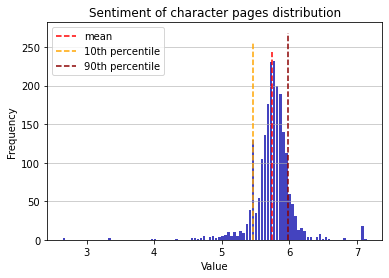

In [83]:
# Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment.
sentiments_distribution = list(sentiments_dict.values())
sentiments_distribution = [item for item in sentiments_distribution if not(math.isnan(item)) == True]

print("The mean value of the sentiment distribution is: ", np.mean(sentiments_distribution))
print("The percentile 10th and 90th are: ", np.percentile(sentiments_distribution, [10,90]))


# Histogram
plt.figure(figsize=(400,40))
fig, ax = plt.subplots()
plt.hist(sentiments_distribution, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(sentiments_distribution), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean", ls = "--", color = "red")
ax.vlines(np.percentile(sentiments_distribution, 10), ax.get_ylim()[0],ax.get_ylim()[1], label = "10th percentile", ls = "--", color = "orange")
ax.vlines(np.percentile(sentiments_distribution, 90), ax.get_ylim()[0],ax.get_ylim()[1], label = "90th percentile", ls = "--", color = "darkred")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sentiment of character pages distribution')

>Now grab the good/bad character names (from this file, see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.



The mean value of the sentiment distribution for good characters is:  5.80206147721171
The percentile 10th and 90th are:  [5.51622643 5.9963989 ]


Text(0.5, 1.0, 'Sentiment distribution for good character pages')

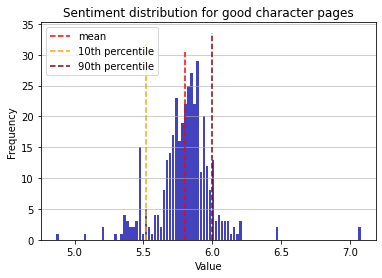

In [97]:
# Statistics for GOOD characters

wiki_meta_data = pd.read_csv('wiki_meta_data.csv', sep=',', header=None)
wiki_meta_data = wiki_meta_data.to_numpy()

# Get good character names
good_characters_indices = np.where(wiki_meta_data[:, 6] == '1')
good_characters = wiki_meta_data[good_characters_indices, 2][0]
good_characters_info = {}

for character in good_characters:
    character_modified = character.replace(" ", "_") #+ '.txt'

    corresponding_node = None
    for node in G.nodes():
        if node == character_modified:
            corresponding_node = node
            break

    if corresponding_node == None:
        continue

    sentiment = G.nodes[corresponding_node]['sentiment']
    good_characters_info[character] = sentiment
    

# Statistics 
good_characters_sentiment = list(good_characters_info.values())
good_characters_sentiment = [item for item in good_characters_sentiment if not(math.isnan(item)) == True] #remove nan

print("The mean value of the sentiment distribution for good characters is: ", np.mean(good_characters_sentiment))
print("The percentile 10th and 90th are: ", np.percentile(good_characters_sentiment, [10,90]))


# Histogram
fig, ax = plt.subplots()
plt.hist(good_characters_sentiment, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(good_characters_sentiment), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean", ls = "--", color = "red")
ax.vlines(np.percentile(good_characters_sentiment, 10), ax.get_ylim()[0],ax.get_ylim()[1], label = "10th percentile", ls = "--", color = "orange")
ax.vlines(np.percentile(good_characters_sentiment, 90), ax.get_ylim()[0],ax.get_ylim()[1], label = "90th percentile", ls = "--", color = "darkred")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sentiment distribution for good character pages')

The mean value of the sentiment distribution for bad characters is:  5.705541069986985
The percentile 10th and 90th are:  [5.50890012 5.87832013]


Text(0.5, 1.0, 'Sentiment of bad character pages distribution')

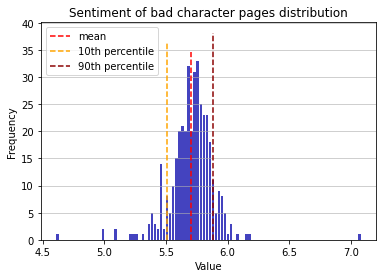

In [98]:
# Statistics for BAD characters

# Get bad character names
bad_characters_indices = np.where(wiki_meta_data[:, 7] == '1')
bad_characters = wiki_meta_data[bad_characters_indices, 2][0]
bad_characters_info = {}

for character in bad_characters:
    character_modified = character.replace(" ", "_")
    
    corresponding_node = None
    for node in G.nodes():
        if node == character_modified:
            corresponding_node = node
            break

    if corresponding_node == None:
        continue

    sentiment = G.nodes[corresponding_node]['sentiment']
    bad_characters_info[character] = sentiment
    

# Statistics
bad_characters_sentiment = list(bad_characters_info.values())
bad_characters_sentiment = [item for item in bad_characters_sentiment if not(math.isnan(item)) == True] #remove nan

print("The mean value of the sentiment distribution for bad characters is: ", np.mean(bad_characters_sentiment))
print("The percentile 10th and 90th are: ", np.percentile(bad_characters_sentiment, [10,90]))

# Histogram
fig, ax = plt.subplots()
plt.hist(bad_characters_sentiment, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(bad_characters_sentiment), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean", ls = "--", color = "red")
ax.vlines(np.percentile(bad_characters_sentiment, 10), ax.get_ylim()[0],ax.get_ylim()[1], label = "10th percentile", ls = "--", color = "orange")
ax.vlines(np.percentile(bad_characters_sentiment, 90), ax.get_ylim()[0],ax.get_ylim()[1], label = "90th percentile", ls = "--", color = "darkred")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sentiment of bad character pages distribution')

>Finally use the label permutation test (see Week 5) to investigate the two hypotheses below:
>- H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
>- H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

>Write a short paragraph reflecting on your findings.

/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_13077/3914121917.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  R = random.sample(G.nodes(), size)


Text(0.5, 1.0, 'Sentiment of bad character pages distribution')

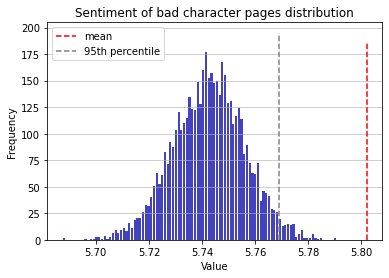

In [90]:
# Label permutation test to investigate H1

import random

size = len(good_characters)
average_sentiment = []

for iteration in range(5000): 
    
    # Select random graph of size of the sub graph of good characters
    R = random.sample(G.nodes(), size)
    sentiments = nx.get_node_attributes(G, "sentiment")
    sentiments_R = [sentiments[k] for k in R if not(math.isnan(sentiments[k])) == True]
    average_sentiment.append(np.mean(sentiments_R))

        
# Histogram
fig, ax = plt.subplots()
plt.hist(average_sentiment, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(good_characters_sentiment), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean", ls = "--", color = "red")
ax.vlines(np.percentile(average_sentiment, 97.5), ax.get_ylim()[0], ax.get_ylim()[1], label = "95th percentile", ls = "--", color = "grey")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sentiment of bad character pages distribution')

/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_13077/4095626306.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  R = random.sample(G.nodes(), size)


Text(0.5, 1.0, 'Permutation distribution for means of bad characters sentiment')

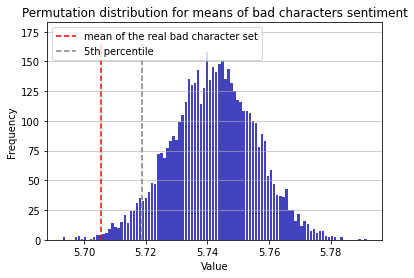

In [91]:
# Label permutation test to investigate H2

size = len(bad_characters)
average_sentiment = []

for iteration in range(5000): 
    # Select random graph of size of the sub graph of bad characters
    R = random.sample(G.nodes(), size)
    sentiments = nx.get_node_attributes(G, "sentiment")
    sentiments_R = [sentiments[k] for k in R if not(math.isnan(sentiments[k])) == True]
    average_sentiment.append(np.mean(sentiments_R))


# Histogram
fig, ax = plt.subplots()
plt.hist(average_sentiment, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(bad_characters_sentiment), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean of the real bad character set", ls = "--", color = "red")
ax.vlines(np.percentile(average_sentiment, 5), ax.get_ylim()[0], ax.get_ylim()[1], label = "5th percentile", ls = "--", color = "grey")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Permutation distribution for means of bad characters sentiment')